In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def accuracy(y, y_pred):
    return np.mean(y == y_pred)

In [3]:
col_names = ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']
col_names = [s.strip().lower().replace(" ", "_") for s in col_names]

In [4]:
df_pred = pd.read_csv("datasets/pred.csv")
df_pred.columns = col_names
df_pred[col_names[-1]][df_pred[col_names[-1]] > 0.5] = 1
df_pred[col_names[-1]][df_pred[col_names[-1]] < 0.5] = 0
df_pred[col_names[-1]] = df_pred[col_names[-1]].astype(int)
df_pred = df_pred.set_index(col_names[0])
print(df_pred.shape)
df_pred.head()

(400, 8)


,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
serial_no.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,1
2,324,107,4,4.0,4.5,8.87,1,1
3,316,104,3,3.0,3.5,8.00,1,1
4,322,110,3,3.5,2.5,8.67,1,1
5,314,103,2,2.0,3.0,8.21,0,1


In [5]:
df_train = pd.read_csv("datasets/train.csv")
df_train.columns = col_names
df_train[col_names[-1]][df_train[col_names[-1]] > 0.5] = 1
df_train[col_names[-1]][df_train[col_names[-1]] < 0.5] = 0
df_train[col_names[-1]] = df_train[col_names[-1]].astype(int)
df_train = df_train.set_index(col_names[0])
print(df_train.shape)
df_train.head()

(500, 8)


,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
serial_no.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,1
2,324,107,4,4.0,4.5,8.87,1,1
3,316,104,3,3.0,3.5,8.00,1,1
4,322,110,3,3.5,2.5,8.67,1,1
5,314,103,2,2.0,3.0,8.21,0,1


#### Check Missing Value

In [6]:
for col in df_train.columns:
    if any(df_train[col].isnull()):
        print("feature %s, missing %i entries"%
             (col, sum(df_train[col].isnull())))
    else:
        print("feature %s has no missing value"%col)

feature gre_score has no missing value
feature toefl_score has no missing value
feature university_rating has no missing value
feature sop has no missing value
feature lor has no missing value
feature cgpa has no missing value
feature research has no missing value
feature chance_of_admit has no missing value


In [7]:
from sklearn.model_selection import train_test_split #for data splitting
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop('chance_of_admit', 1), df_train[['chance_of_admit']], 
    test_size = .2, 
    random_state=0)

In [8]:
X_train.dtypes

gre_score              int64
toefl_score            int64
university_rating      int64
sop                  float64
lor                  float64
cgpa                 float64
research               int64
dtype: object

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(400, 7) (400, 1)
(100, 7) (100, 1)


In [10]:
# class balance
sum(y_train.chance_of_admit) / len(y_train)

0.9175

#### Feature Distribution

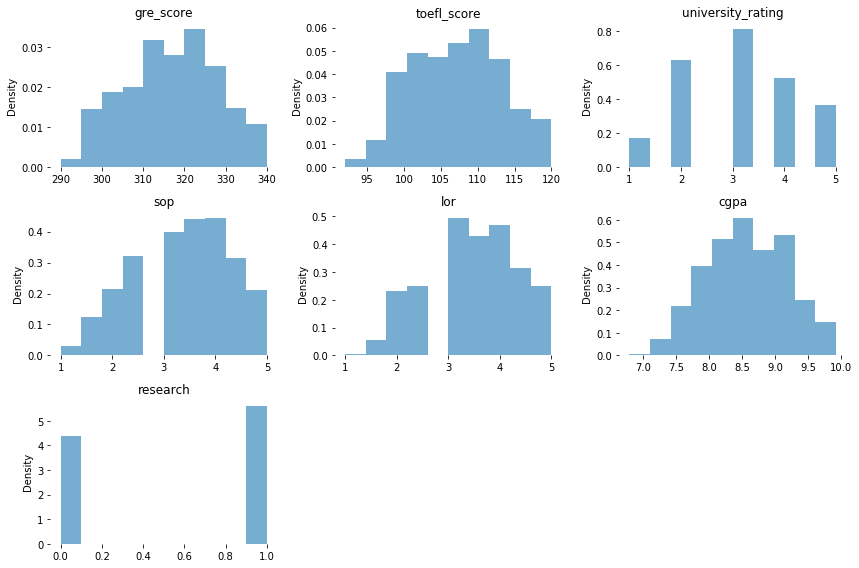

In [11]:
plt.figure(figsize=(12, 8))

# subplot setup
ncols = 3
nrows = 3

for i, col in enumerate(X_train.columns):
    x = df_train[col].values

    # parameter: number of rows, number of columns, plot index
    ax = plt.subplot(nrows, ncols, i + 1)
    
    # can be any type of plot (histogram, pie, line etc.)
    ax.hist(x, density=True, alpha = 0.6, label=col)
    
    ax.set_ylabel("Density")
    ax.set_title(col)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

# use tight layout so texts don't overlap
plt.tight_layout()

#### Linear Model

In [12]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train, y_train)
cv_results = cross_validate(lr, X_train, y_train, cv=10, 
                            scoring=('r2', 'accuracy'), 
                            return_train_score=False)
print("avg accuracy: %.10f"%np.mean(cv_results["test_accuracy"]))

avg accuracy: 0.9201547842


In [13]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# estimator = SVR(kernel="linear")
hist = []
features = {}
for i in range(1, len(X_train.columns)):
    selector = RFE(lr, i, step=1)
    selector = selector.fit(X_train, y_train)
    selected = X_train.columns[selector.support_]
    features[i] = selected

    cv_results = cross_validate(lr, X_train[selected], y_train, cv=10, 
                                scoring=('r2', 'accuracy'), 
                                return_train_score=False)
    avg_acc = np.mean(cv_results["test_accuracy"])
    print("%i features, avg accuracy: %.10f"%(i + 1, avg_acc))
    
    hist.append(avg_acc)

2 features, avg accuracy: 0.9302892433
3 features, avg accuracy: 0.9374749844
4 features, avg accuracy: 0.9349749844
5 features, avg accuracy: 0.9451063164
6 features, avg accuracy: 0.9297858036
7 features, avg accuracy: 0.9324108818


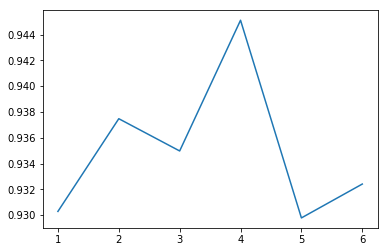

In [14]:
plt.plot(list(range(1, len(X_train.columns))), hist)

In [15]:
selected = features[4]

In [16]:
lr.fit(X_train[selected], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

#### Bagged Tree 

In [17]:
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting

In [18]:
model = RandomForestClassifier(max_depth=5, n_estimators=50)
model.fit(X_train, y_train.values.reshape(-1, ))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str = y_train_str.values

In [21]:
# #code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = feature_names,
#                 class_names = y_train_str,
#                 rounded = True, proportion = True, 
#                 label='root',
#                 precision = 2, filled = True)

# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# from IPython.display import Image
# Image(filename = 'tree.png')

#### Boosted Tree

In [22]:
import xgboost as xgb

features = X_train.columns
features = selected

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train[features], y_train[col_names[-1]])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [23]:
y_predict = xgc.predict(X_train[features])
y_pred_quant = xgc.predict_proba(X_train[features])[:, 1]
y_pred_bin = xgc.predict(X_train[features])

In [24]:
cm = confusion_matrix(y_train, y_pred_bin)
cm

array([[ 32,   1],
       [  0, 367]])

In [25]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity)

specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

Sensitivity :  1.0
Specificity :  0.9972826086956522


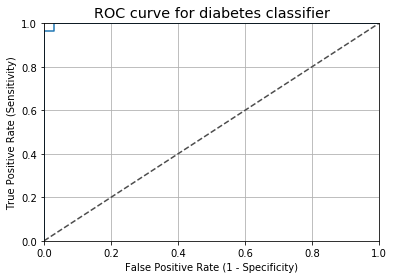

In [26]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [27]:
auc(fpr, tpr)

0.9989265956568409

In [28]:
y_predict = (model.predict_proba(X_train)[:,1] >= 0.2).astype(bool)
cm = confusion_matrix(y_train, y_predict)
cm

array([[ 10,  23],
       [  0, 367]])

In [29]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

Sensitivity :  1.0
Specificity :  0.941025641025641


In [30]:
from sklearn.model_selection import ShuffleSplit

n_splits = 10
rs = ShuffleSplit(n_splits=n_splits, test_size=.25, random_state=0)

accs = []
for i, (train_index, test_index) in enumerate(rs.split(X_train.index)):
    X_train_fold = X_train.iloc[train_index][features]
    y_train_fold = y_train.iloc[train_index].values.reshape(-1, )
    
    X_test_fold = X_train.iloc[test_index][features]
    y_test_fold = y_train.iloc[test_index].values.reshape(-1, )
    
    xgc_ = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
    xgc_.fit(X_train_fold, y_train_fold)
    
    y_pred = (xgc_.predict_proba(X_test_fold)[:,1] >= 0.2).astype(bool)

    acc = accuracy(y_test_fold, y_pred)
    accs.append(acc)
    print("fold %i, acc = %.5f"%(i, acc))

print("%i-fold cross validation, average acc %.5f, standard error %.5f"
      %(n_splits, np.mean(accs), np.std(accs, ddof=1)))

fold 0, acc = 0.94000
fold 1, acc = 0.94000
fold 2, acc = 0.93000
fold 3, acc = 0.92000
fold 4, acc = 0.95000
fold 5, acc = 0.92000
fold 6, acc = 0.93000
fold 7, acc = 0.89000
fold 8, acc = 0.91000
fold 9, acc = 0.95000
10-fold cross validation, average acc 0.92800, standard error 0.01874


#### Test Set

In [31]:
# baseline
np.mean(y_test)

chance_of_admit    0.94
dtype: float64

In [32]:
# logistic regression accuracy
y_test_pred = lr.predict(X_test[selected])
accuracy(y_test.values.reshape(-1, ), y_test_pred)

0.94

In [33]:
# xgboost accuracy
y_test_pred = (xgc_.predict_proba(X_test[features])[:,1] >= 0.2).astype(bool)
accuracy(y_test.values.reshape(-1, ), y_test_pred)

0.93

In [34]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[ 2,  4],
       [ 3, 91]])

In [35]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity)

specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.4
Specificity :  0.9578947368421052


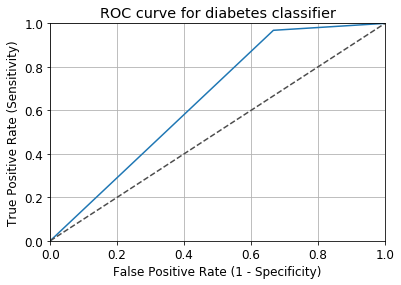

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [37]:
auc(fpr, tpr)

0.6507092198581561

#### Interpretation

In [38]:
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgc, random_state=1).fit(X_test[features], y_test)
eli5.show_weights(perm, feature_names = features.tolist())

Weight,Feature
0.0300 ± 0.0219,sop
0.0280 ± 0.0150,gre_score
0.0220 ± 0.0150,cgpa
0.0020 ± 0.0080,lor


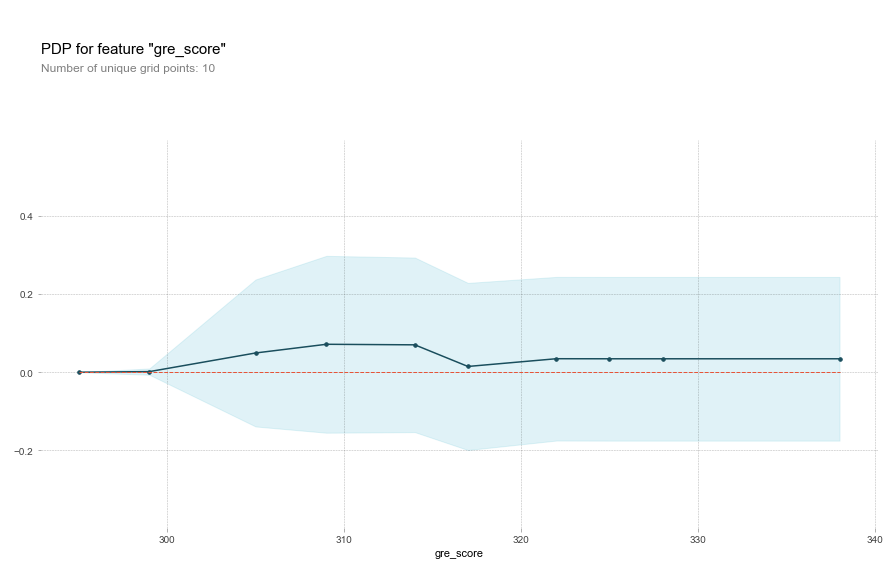

In [39]:
from pdpbox import pdp, info_plots #for partial plots

base_features = features.tolist()

feat_name = features[0]
pdp_dist = pdp.pdp_isolate(model=xgc, dataset=X_test[features], model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

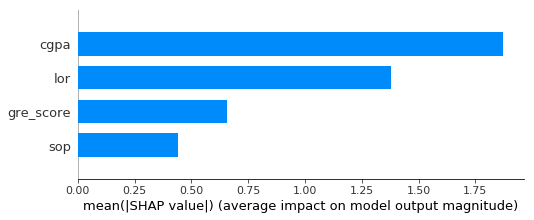

In [40]:
import shap 

explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_train[features])

shap.summary_plot(shap_values, X_train[features], plot_type="bar")

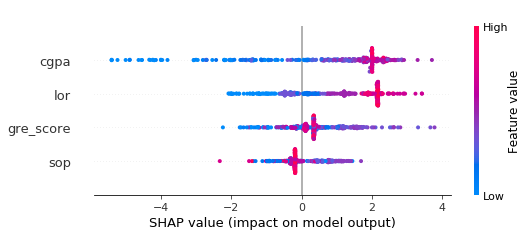

In [41]:
shap.summary_plot(shap_values, X_train[features])

In [42]:
def plot_force_for_instance(model, example):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(example)
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, example)

In [43]:
data_for_prediction = X_test[features].iloc[6].astype(float)
plot_force_for_instance(xgc, data_for_prediction)

In [44]:
data_for_prediction = X_test[features].iloc[2].astype(float)
plot_force_for_instance(xgc, data_for_prediction)

In [45]:
shap_values = explainer.shap_values(X_test[features].iloc[:50])
shap.force_plot(explainer.expected_value, shap_values, X_test[features].iloc[:50])